In [1]:
from pathlib import Path
import json

# Local analysis helpers (same folder as this notebook)
from testLibs import ResultsFlattener, mznResultsFlattener

data_dir = Path("../../data/testOutputFree").resolve()
if not data_dir.is_dir():
    raise FileNotFoundError(f"Expected folder not found: {data_dir}")

json_paths = sorted(data_dir.glob("*.json"))
print(f"Loading {len(json_paths)} JSON files from {data_dir}")

data_by_file = {}
for p in json_paths:
    with p.open("r", encoding="utf-8") as f:
        data_by_file[p.name] = json.load(f)

# Convenience: list in a stable order, matching json_paths
data_list = [data_by_file[p.name] for p in json_paths]

print("Loaded files:")
for name in data_by_file.keys():
    print(" -", name)

with open('../data/tablesJSON/allTables_free.json', 'r') as f5:
    MznResults = json.load(f5)

Loading 16 JSON files from /home/vro5/Coding/AgenticSolvers/data/testOutputFree
Loaded files:
 - LLMsuggestions_chat_Pdesc_Sdesc_T0.json
 - LLMsuggestions_chat_Pdesc_Sdesc_T0p2.json
 - LLMsuggestions_chat_Pdesc_Sdesc_T0p3.json
 - LLMsuggestions_chat_Pdesc_Sdesc_T0p7.json
 - LLMsuggestions_chat_Pdesc_Sdesc_T0p8.json
 - LLMsuggestions_featOnly_Pdesc_T0.json
 - LLMsuggestions_featOnly_Pdesc_T0p2.json
 - LLMsuggestions_featOnly_Pdesc_T0p3.json
 - LLMsuggestions_featOnly_Pdesc_T0p7.json
 - LLMsuggestions_featOnly_Pdesc_T0p8.json
 - LLMsuggestions_featOnly_Sdesc_T0p2.json
 - LLMsuggestions_free_uncommented_T0.json
 - LLMsuggestions_free_uncommented_T0p2.json
 - LLMsuggestions_free_uncommented_T0p3.json
 - LLMsuggestions_free_uncommented_T0p7.json
 - LLMsuggestions_free_uncommented_T0p8.json


In [2]:
# Flatten each loaded LLM JSON file into its own dataframe (and keep metadata)
import re
import pandas as pd

def parse_variant_and_temperature(filename: str) -> tuple[str | None, str | None]:
    """Extract variant + temperature from filenames like:
    - LLMsuggestions_chat_Pdesc_Sdesc_T0.json         -> (Pdesc_Sdesc, T0)
    - LLMsuggestions_featOnly_Pdesc_T0p2.json         -> (featOnly_Pdesc, T0p2)
    - LLMsuggestions_free_uncommented_T0p7.json       -> (free_uncommented, T0p7)
    Also supports keys like 'testOutputFree/LLMsuggestions_...json' by using the basename.
    """
    filename = str(filename).split('/')[-1]
    base = filename
    if base.endswith('.json'):
        base = base[:-5]
    if base.startswith('LLMsuggestions_'):
        base = base[len('LLMsuggestions_'):]

    parts = base.split('_')
    temperature = parts[-1] if parts and parts[-1].startswith('T') else None

    variant_part = base
    if temperature is not None and base.endswith('_' + temperature):
        variant_part = base[:-(len(temperature) + 1)]

    variant = variant_part[len('chat_'):] if variant_part.startswith('chat_') else variant_part

    if temperature is None:
        m = re.search(r'(T\d+(?:p\d+)?)', base)
        if m:
            temperature = m.group(1)

    return variant or None, temperature or None

llm_df_by_file: dict[str, pd.DataFrame] = {}
llm_meta_by_file: dict[str, dict] = {}

for fname, payload in data_by_file.items():
    df = ResultsFlattener(payload)
    # Provider is not used downstream; drop it to avoid confusion.
    df = df.drop(columns=['provider'], errors='ignore')
    variant, temperature = parse_variant_and_temperature(fname)
    llm_df_by_file[fname] = df
    llm_meta_by_file[fname] = {
        'source_file': fname,
        'variant': variant,
        'temperature': temperature,
    }

# Optional convenience: combined dataframe for exploratory analysis (not used for scoring)
llm_df_all = pd.concat(
    [
        df.assign(**llm_meta_by_file[fname])
        for fname, df in llm_df_by_file.items()
        if df is not None and not df.empty
    ],
    ignore_index=True,
 )

display(llm_df_all.head() if not llm_df_all.empty else "No LLM rows produced")

# Quick check: see parsed filename metadata
meta_df = pd.DataFrame.from_dict(llm_meta_by_file, orient='index')
display(meta_df.sort_values(['variant', 'temperature', 'source_file']).reset_index(drop=True))

# Flatten MiniZinc results too (as before)
mzn_df = mznResultsFlattener(MznResults)
display(mzn_df.head())

,model,problem,instance,top3_list,top3,top1,time_seconds,source_file,variant,temperature
0,openai/gpt-oss-120b,atsp,instance11_0p25,"[or-tools_cp-sat-free, chuffed-free, cp_optimi...","or-tools_cp-sat-free, chuffed-free, cp_optimiz...",or-tools_cp-sat-free,NaN,LLMsuggestions_chat_Pdesc_Sdesc_T0.json,Pdesc_Sdesc,T0
1,openai/gpt-oss-120b,atsp,instance14_0p25,"[or-tools_cp-sat-free, chuffed-free, cp_optimi...","or-tools_cp-sat-free, chuffed-free, cp_optimiz...",or-tools_cp-sat-free,NaN,LLMsuggestions_chat_Pdesc_Sdesc_T0.json,Pdesc_Sdesc,T0
2,openai/gpt-oss-120b,atsp,instance1_0p05,"[or-tools_cp-sat-free, chuffed-free, cp_optimi...","or-tools_cp-sat-free, chuffed-free, cp_optimiz...",or-tools_cp-sat-free,NaN,LLMsuggestions_chat_Pdesc_Sdesc_T0.json,Pdesc_Sdesc,T0
3,openai/gpt-oss-120b,atsp,instance20_0p35,"[or-tools_cp-sat-free, chuffed-free, cp_optimi...","or-tools_cp-sat-free, chuffed-free, cp_optimiz...",or-tools_cp-sat-free,NaN,LLMsuggestions_chat_Pdesc_Sdesc_T0.json,Pdesc_Sdesc,T0
4,openai/gpt-oss-120b,atsp,instance4_0p15,"[or-tools_cp-sat-free, chuffed-free, cp_optimi...","or-tools_cp-sat-free, chuffed-free, cp_optimiz...",or-tools_cp-sat-free,NaN,LLMsuggestions_chat_Pdesc_Sdesc_T0.json,Pdesc_Sdesc,T0


,source_file,variant,temperature
0,LLMsuggestions_chat_Pdesc_Sdesc_T0.json,Pdesc_Sdesc,T0
1,LLMsuggestions_chat_Pdesc_Sdesc_T0p2.json,Pdesc_Sdesc,T0p2
2,LLMsuggestions_chat_Pdesc_Sdesc_T0p3.json,Pdesc_Sdesc,T0p3
3,LLMsuggestions_chat_Pdesc_Sdesc_T0p7.json,Pdesc_Sdesc,T0p7
4,LLMsuggestions_chat_Pdesc_Sdesc_T0p8.json,Pdesc_Sdesc,T0p8
5,LLMsuggestions_featOnly_Pdesc_T0.json,featOnly_Pdesc,T0
6,LLMsuggestions_featOnly_Pdesc_T0p2.json,featOnly_Pdesc,T0p2
7,LLMsuggestions_featOnly_Pdesc_T0p3.json,featOnly_Pdesc,T0p3
8,LLMsuggestions_featOnly_Pdesc_T0p7.json,featOnly_Pdesc,T0p7
9,LLMsuggestions_featOnly_Pdesc_T0p8.json,featOnly_Pdesc,T0p8


,Problem,Category,Instance,Solver,Status,Time,Objective,Score,Score Area
0,EchoSched,MIN,12-12-0-1_7,atlantis-free,UNK,1200000.0,NaN,0.00,1200000.00
1,EchoSched,MIN,12-12-0-1_7,cbc-free,S,1200000.0,12172.0,5.00,326862.67
2,EchoSched,MIN,12-12-0-1_7,choco-solver__cp_-free,SC,38449.0,12135.0,10.54,14001.39
3,EchoSched,MIN,12-12-0-1_7,choco-solver__cp-sat_-free,SC,48686.0,12135.0,10.03,17561.17
4,EchoSched,MIN,12-12-0-1_7,chuffed-free,SC,6508.0,12135.0,15.05,4352.61


In [3]:
# Top-3 (parallel) score evaluation using compute_llm_scores
# IMPORTANT: run scoring per-file/per-(variant,temperature) BEFORE any combination
import pandas as pd
from testLibs import scoreComputation, compute_llm_scores

# 1) Compute per-solver scores from MiniZinc results
scored_df = scoreComputation(mzn_df)

# 2) Score each JSON file independently (each corresponds to one variant/temperature)
score_parts = []
for fname, llm_df in llm_df_by_file.items():
    if llm_df is None or llm_df.empty:
        continue
    meta = llm_meta_by_file.get(fname, {})
    # Keep only columns needed by compute_llm_scores to avoid accidental breakage
    needed = ['model', 'problem', 'instance', 'top3_list']
    llm_df_clean = llm_df[needed].copy()
    # compute_llm_scores currently groups by ['provider','model']; set a dummy provider and drop later
    llm_df_clean['provider'] = 'all'
    part = compute_llm_scores(llm_df_clean, scored_df)
    part = part.drop(columns=['provider'], errors='ignore')
    part['variant'] = meta.get('variant')
    part['temperature'] = meta.get('temperature')
    part['source_file'] = meta.get('source_file', fname)
    score_parts.append(part)

llm_top3_by_variant_temp = pd.concat(score_parts, ignore_index=True) if score_parts else pd.DataFrame()

# 3) Display ranking (across all variant/temperature combos)
if not llm_top3_by_variant_temp.empty:
    llm_top3_by_variant_temp = llm_top3_by_variant_temp.sort_values(
        ['variant', 'temperature', 'LLM_TotalScore', 'LLM_AvgScore'],
        ascending=[True, True, False, False],
    )
    display(llm_top3_by_variant_temp)
else:
    display("No Top-3 scores produced")

# Optional: quick sanity checks
print("Files scored:", len(score_parts))
print("Rows in scored_df:", len(scored_df))

/home/vro5/Coding/AgenticSolvers/test/notebooks/testLibs.py:109: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg = valid_objs.groupby(['Problem', 'Instance']).apply(best_worst).reset_index()


,model,LLM_TotalScore,InstancesCovered,LLM_AvgScore,variant,temperature,source_file
0,openai/gpt-oss-120b,82.041507,99,0.828702,Pdesc_Sdesc,T0,LLMsuggestions_chat_Pdesc_Sdesc_T0.json
1,openai/gpt-oss-120b,82.041507,99,0.828702,Pdesc_Sdesc,T0p2,LLMsuggestions_chat_Pdesc_Sdesc_T0p2.json
2,openai/gpt-oss-120b,80.041507,96,0.833766,Pdesc_Sdesc,T0p3,LLMsuggestions_chat_Pdesc_Sdesc_T0p3.json
3,openai/gpt-oss-120b,79.041507,96,0.823349,Pdesc_Sdesc,T0p7,LLMsuggestions_chat_Pdesc_Sdesc_T0p7.json
4,openai/gpt-oss-120b,80.874840,98,0.825253,Pdesc_Sdesc,T0p8,LLMsuggestions_chat_Pdesc_Sdesc_T0p8.json
5,openai/gpt-oss-120b,81.455581,99,0.822784,featOnly_Pdesc,T0,LLMsuggestions_featOnly_Pdesc_T0.json
6,openai/gpt-oss-120b,83.362639,99,0.842047,featOnly_Pdesc,T0p2,LLMsuggestions_featOnly_Pdesc_T0p2.json
7,openai/gpt-oss-120b,82.392525,98,0.840740,featOnly_Pdesc,T0p3,LLMsuggestions_featOnly_Pdesc_T0p3.json
8,openai/gpt-oss-120b,81.895640,98,0.835670,featOnly_Pdesc,T0p7,LLMsuggestions_featOnly_Pdesc_T0p7.json
9,openai/gpt-oss-120b,83.008793,100,0.830088,featOnly_Pdesc,T0p8,LLMsuggestions_featOnly_Pdesc_T0p8.json


Files scored: 16
Rows in scored_df: 2000


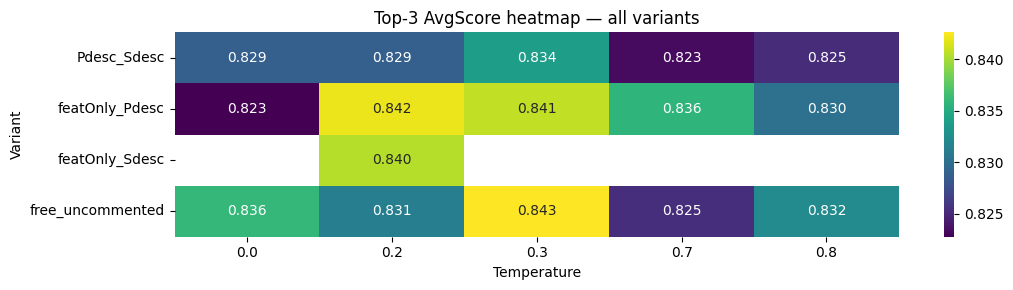

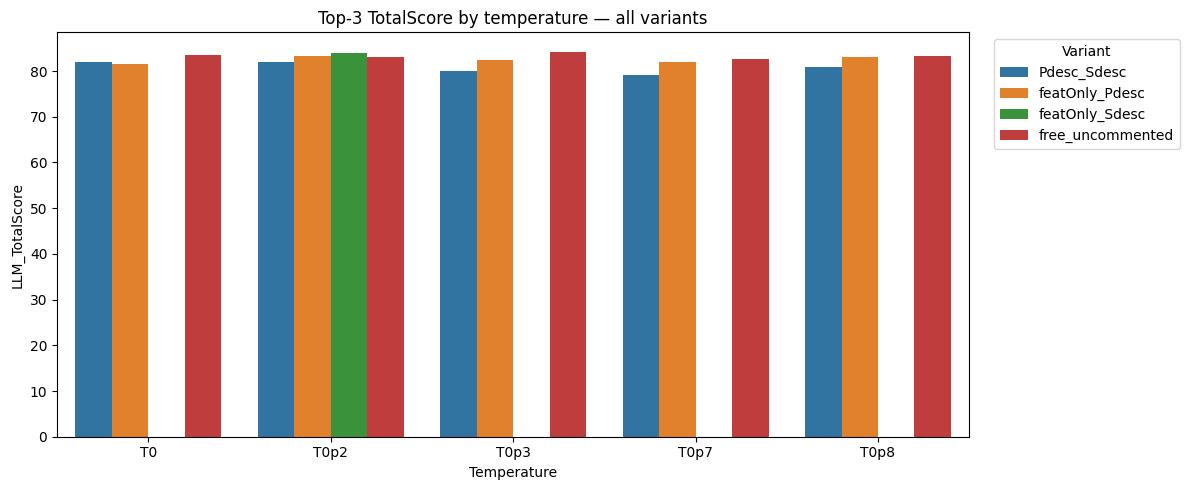

In [4]:
# Plots for Top-3 (parallel) scores by variant/temperature
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

if llm_top3_by_variant_temp is None or llm_top3_by_variant_temp.empty:
    raise ValueError("No data in llm_top3_by_variant_temp. Run Cells 1-3 first.")

plot_df = llm_top3_by_variant_temp.copy()
plot_df['ModelLabel'] = plot_df['model'].astype(str)
plot_df['VariantLabel'] = plot_df['variant'].astype(str)

def _temp_to_float(t: str) -> float | None:
    if t is None or (isinstance(t, float) and np.isnan(t)):
        return None
    t = str(t)
    m = re.fullmatch(r"T(\d+)(?:p(\d+))?", t)
    if not m:
        return None
    whole = int(m.group(1))
    frac = m.group(2)
    if frac is None:
        return float(whole)
    return float(f"{whole}.{frac}")

plot_df['temp_f'] = plot_df['temperature'].apply(_temp_to_float)
plot_df = plot_df.dropna(subset=['variant', 'temp_f']).copy()
plot_df['temp_f'] = plot_df['temp_f'].astype(float)

# Order temperatures left-to-right using numeric temp_f
temp_order = (
    plot_df[['temperature', 'temp_f']]
    .drop_duplicates()
    .sort_values('temp_f')
    ['temperature']
    .tolist()
)

# --- Combined plots (all variants together) ---
pivot_all = (
    plot_df.pivot_table(
        index='VariantLabel',
        columns='temp_f',
        values='LLM_AvgScore',
        aggfunc='mean',
    )
    .sort_index(axis=0)
    .sort_index(axis=1)
)

plt.figure(figsize=(11, max(3, 0.55 * len(pivot_all.index))))
sns.heatmap(pivot_all, annot=True, fmt='.3f', cmap='viridis')
plt.title("Top-3 AvgScore heatmap — all variants")
plt.xlabel('Temperature')
plt.ylabel('Variant')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
sns.barplot(data=plot_df, x='temperature', y='LLM_TotalScore', hue='VariantLabel', order=temp_order)
plt.title("Top-3 TotalScore by temperature — all variants")
plt.xlabel('Temperature')
plt.ylabel('LLM_TotalScore')
plt.legend(title='Variant', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [5]:
# Top-1 score evaluation using compute_top1_llm_scores (per file / per variant+temperature)
import pandas as pd
from testLibs import compute_top1_llm_scores

# Score each JSON file independently (each corresponds to one variant/temperature)
top1_score_parts = []
llm_top1_scored_by_file: dict[str, pd.DataFrame] = {}

for fname, llm_df in llm_df_by_file.items():
    if llm_df is None or llm_df.empty:
        continue
    meta = llm_meta_by_file.get(fname, {})

    # Keep only columns needed by compute_top1_llm_scores to avoid accidental breakage
    needed = ['model', 'problem', 'instance', 'top1']
    missing = [c for c in needed if c not in llm_df.columns]
    if missing:
        # If a file doesn't have top1 (unexpected), skip it rather than crash the notebook
        print(f"Skipping {fname}: missing columns {missing}")
        continue

    llm_df_clean = llm_df[needed].copy()
    # compute_top1_llm_scores currently groups by ['provider','model']; set a dummy provider and drop later
    llm_df_clean['provider'] = 'all'

    top1_summary, top1_scored = compute_top1_llm_scores(llm_df_clean, scored_df)
    top1_summary = top1_summary.drop(columns=['provider'], errors='ignore')
    top1_summary['variant'] = meta.get('variant')
    top1_summary['temperature'] = meta.get('temperature')
    top1_summary['source_file'] = meta.get('source_file', fname)
    top1_score_parts.append(top1_summary)

    llm_top1_scored_by_file[fname] = top1_scored

llm_top1_by_variant_temp = pd.concat(top1_score_parts, ignore_index=True) if top1_score_parts else pd.DataFrame()

# Display ranking (across all variant/temperature combos)
if not llm_top1_by_variant_temp.empty:
    llm_top1_by_variant_temp = llm_top1_by_variant_temp.sort_values(
        ['variant', 'temperature', 'LLM_Top1_TotalScore', 'LLM_Top1_AvgScore'],
        ascending=[True, True, False, False],
    )
    display(llm_top1_by_variant_temp)
else:
    display("No Top-1 scores produced")

print("Files Top-1 scored:", len(top1_score_parts))

,model,LLM_Top1_TotalScore,LLM_Top1_AvgScore,InstancesCovered,variant,temperature,source_file
0,openai/gpt-oss-120b,76.970940,0.777484,99,Pdesc_Sdesc,T0,LLMsuggestions_chat_Pdesc_Sdesc_T0.json
1,openai/gpt-oss-120b,71.716584,0.739346,99,Pdesc_Sdesc,T0p2,LLMsuggestions_chat_Pdesc_Sdesc_T0p2.json
2,openai/gpt-oss-120b,74.907293,0.780284,96,Pdesc_Sdesc,T0p3,LLMsuggestions_chat_Pdesc_Sdesc_T0p3.json
3,openai/gpt-oss-120b,69.890422,0.735689,96,Pdesc_Sdesc,T0p7,LLMsuggestions_chat_Pdesc_Sdesc_T0p7.json
4,openai/gpt-oss-120b,72.894407,0.743820,98,Pdesc_Sdesc,T0p8,LLMsuggestions_chat_Pdesc_Sdesc_T0p8.json
5,openai/gpt-oss-120b,73.113711,0.746058,99,featOnly_Pdesc,T0,LLMsuggestions_featOnly_Pdesc_T0.json
6,openai/gpt-oss-120b,76.298081,0.770688,99,featOnly_Pdesc,T0p2,LLMsuggestions_featOnly_Pdesc_T0p2.json
7,openai/gpt-oss-120b,72.678151,0.741614,98,featOnly_Pdesc,T0p3,LLMsuggestions_featOnly_Pdesc_T0p3.json
8,openai/gpt-oss-120b,71.235173,0.726890,98,featOnly_Pdesc,T0p7,LLMsuggestions_featOnly_Pdesc_T0p7.json
9,openai/gpt-oss-120b,75.675960,0.756760,100,featOnly_Pdesc,T0p8,LLMsuggestions_featOnly_Pdesc_T0p8.json


Files Top-1 scored: 16


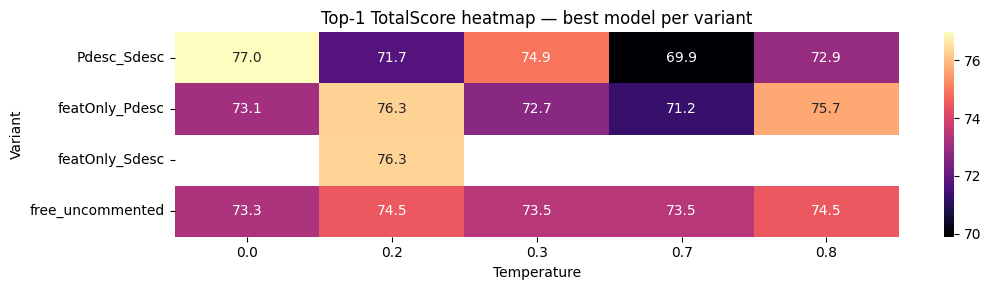

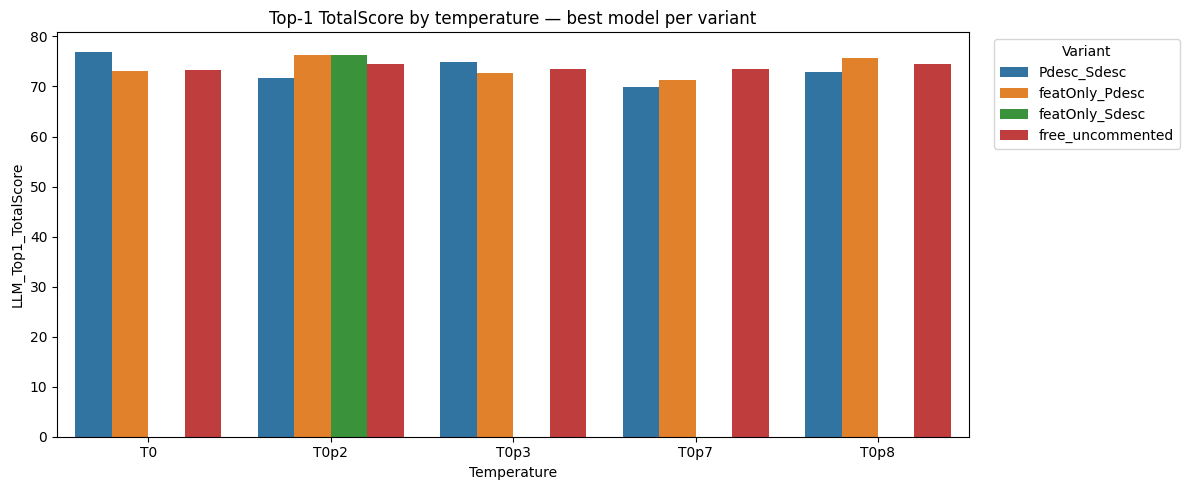

In [6]:
# Plot: Top-1 total score by variant/temperature
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

if llm_top1_by_variant_temp is None or llm_top1_by_variant_temp.empty:
    raise ValueError("No data in llm_top1_by_variant_temp. Run Cells 1-5 first.")

plot_df = llm_top1_by_variant_temp.copy()
plot_df['ModelLabel'] = plot_df['model'].astype(str)
plot_df['VariantLabel'] = plot_df['variant'].astype(str)

def _temp_to_float(t: str) -> float | None:
    if t is None or (isinstance(t, float) and np.isnan(t)):
        return None
    t = str(t)
    m = re.fullmatch(r"T(\d+)(?:p(\d+))?", t)
    if not m:
        return None
    whole = int(m.group(1))
    frac = m.group(2)
    if frac is None:
        return float(whole)
    return float(f"{whole}.{frac}")

plot_df['temp_f'] = plot_df['temperature'].apply(_temp_to_float)
plot_df = plot_df.dropna(subset=['variant', 'temp_f']).copy()
plot_df['temp_f'] = plot_df['temp_f'].astype(float)

# Order temperatures left-to-right using numeric temp_f
temp_order = (
    plot_df[['temperature', 'temp_f']]
    .drop_duplicates()
    .sort_values('temp_f')
    ['temperature']
    .tolist()
 )

# If there are multiple models per (variant,temperature), plot the best one per combo
best_df = (
    plot_df.sort_values(['VariantLabel', 'temp_f', 'LLM_Top1_TotalScore'], ascending=[True, True, False])
    .groupby(['VariantLabel', 'temperature', 'temp_f'], as_index=False)
    .head(1)
    .reset_index(drop=True)
 )

# Heatmap: Top-1 TotalScore (best model per variant/temp)
pivot_total = (
    best_df.pivot_table(
    index='VariantLabel',
    columns='temp_f',
    values='LLM_Top1_TotalScore',
    aggfunc='mean',
    )
    .sort_index(axis=0)
    .sort_index(axis=1)
 )

plt.figure(figsize=(11, max(3, 0.55 * len(pivot_total.index))))
sns.heatmap(pivot_total, annot=True, fmt='.1f', cmap='magma')
plt.title("Top-1 TotalScore heatmap — best model per variant")
plt.xlabel('Temperature')
plt.ylabel('Variant')
plt.tight_layout()
plt.show()

# Barplot: Top-1 TotalScore by temperature (best model per variant/temp)
plt.figure(figsize=(12, 5))
sns.barplot(data=best_df, x='temperature', y='LLM_Top1_TotalScore', hue='VariantLabel', order=temp_order)
plt.title("Top-1 TotalScore by temperature — best model per variant")
plt.xlabel('Temperature')
plt.ylabel('LLM_Top1_TotalScore')
plt.legend(title='Variant', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [7]:
# Closed Gap evaluation for all variant/temperature combinations (per file)
import pandas as pd
from testLibs import compute_closed_gap

if 'llm_top1_scored_by_file' not in globals() or llm_top1_scored_by_file is None:
    raise ValueError("llm_top1_scored_by_file not found. Run Cells 1-5 first.")

cg_parts: list[pd.DataFrame] = []
for fname, top1_scored in llm_top1_scored_by_file.items():
    if top1_scored is None or (isinstance(top1_scored, pd.DataFrame) and top1_scored.empty):
        continue
    meta = llm_meta_by_file.get(fname, {})

    cg_results = compute_closed_gap(top1_scored, scored_df)
    if not cg_results:
        continue
    part = pd.DataFrame(cg_results)
    part = part.drop(columns=['provider'], errors='ignore')
    part['variant'] = meta.get('variant')
    part['temperature'] = meta.get('temperature')
    part['source_file'] = meta.get('source_file', fname)
    cg_parts.append(part)

closed_gap_by_variant_temp = pd.concat(cg_parts, ignore_index=True) if cg_parts else pd.DataFrame()

if not closed_gap_by_variant_temp.empty:
    closed_gap_by_variant_temp = closed_gap_by_variant_temp.sort_values(
        ['variant', 'temperature', 'ClosedGap'], ascending=[True, True, False]
    ).reset_index(drop=True)
    display(closed_gap_by_variant_temp)
else:
    display("No Closed Gap results produced")

print("Files with Closed Gap computed:", len(cg_parts))

,model,InstancesCovered,AS,SBS,VBS,ClosedGap,variant,temperature,source_file
0,openai/gpt-oss-120b,99,76.970940,76.964375,89.0,0.000545,Pdesc_Sdesc,T0,LLMsuggestions_chat_Pdesc_Sdesc_T0.json
1,openai/gpt-oss-120b,99,71.716584,76.964375,89.0,-0.436021,Pdesc_Sdesc,T0p2,LLMsuggestions_chat_Pdesc_Sdesc_T0p2.json
2,openai/gpt-oss-120b,96,74.907293,76.964375,89.0,-0.170916,Pdesc_Sdesc,T0p3,LLMsuggestions_chat_Pdesc_Sdesc_T0p3.json
3,openai/gpt-oss-120b,96,69.890422,76.964375,89.0,-0.587751,Pdesc_Sdesc,T0p7,LLMsuggestions_chat_Pdesc_Sdesc_T0p7.json
4,openai/gpt-oss-120b,98,72.894407,76.964375,89.0,-0.338160,Pdesc_Sdesc,T0p8,LLMsuggestions_chat_Pdesc_Sdesc_T0p8.json
5,openai/gpt-oss-120b,99,73.113711,76.964375,89.0,-0.319939,featOnly_Pdesc,T0,LLMsuggestions_featOnly_Pdesc_T0.json
6,openai/gpt-oss-120b,99,76.298081,76.964375,89.0,-0.055360,featOnly_Pdesc,T0p2,LLMsuggestions_featOnly_Pdesc_T0p2.json
7,openai/gpt-oss-120b,98,72.678151,76.964375,89.0,-0.356128,featOnly_Pdesc,T0p3,LLMsuggestions_featOnly_Pdesc_T0p3.json
8,openai/gpt-oss-120b,98,71.235173,76.964375,89.0,-0.476020,featOnly_Pdesc,T0p7,LLMsuggestions_featOnly_Pdesc_T0p7.json
9,openai/gpt-oss-120b,100,75.675960,76.964375,89.0,-0.107050,featOnly_Pdesc,T0p8,LLMsuggestions_featOnly_Pdesc_T0p8.json


Files with Closed Gap computed: 16


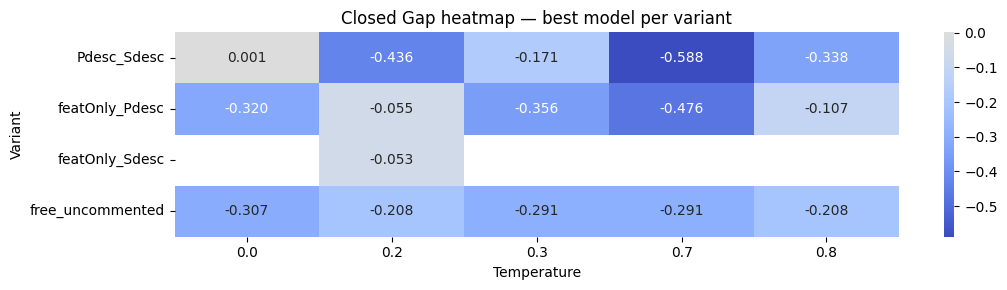

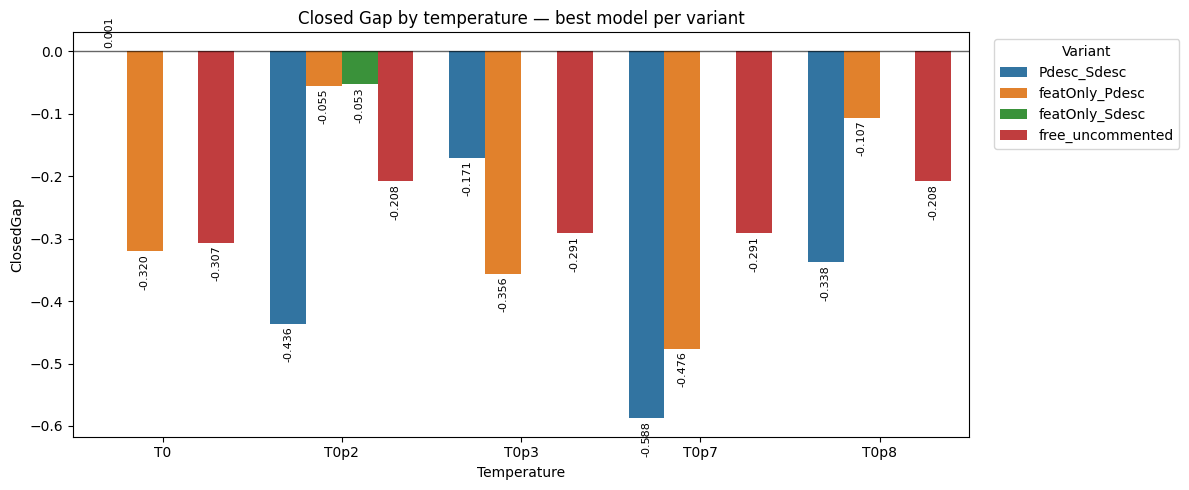

In [8]:
# Plots for Closed Gap by variant/temperature
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

if closed_gap_by_variant_temp is None or closed_gap_by_variant_temp.empty:
    raise ValueError("No data in closed_gap_by_variant_temp. Run Cells 1-7 first.")

plot_df = closed_gap_by_variant_temp.copy()
plot_df['VariantLabel'] = plot_df['variant'].astype(str)

def _temp_to_float(t: str) -> float | None:
    if t is None or (isinstance(t, float) and np.isnan(t)):
        return None
    t = str(t)
    m = re.fullmatch(r"T(\d+)(?:p(\d+))?", t)
    if not m:
        return None
    whole = int(m.group(1))
    frac = m.group(2)
    if frac is None:
        return float(whole)
    return float(f"{whole}.{frac}")

plot_df['temp_f'] = plot_df['temperature'].apply(_temp_to_float)
plot_df = plot_df.dropna(subset=['variant', 'temp_f', 'ClosedGap']).copy()
plot_df['temp_f'] = plot_df['temp_f'].astype(float)

# Order temperatures left-to-right using numeric temp_f
temp_order = (
    plot_df[['temperature', 'temp_f']]
    .drop_duplicates()
    .sort_values('temp_f')
    ['temperature']
    .tolist()
 )

# If there are multiple models per (variant,temperature), plot the best one per combo (max ClosedGap)
best_cg_df = (
    plot_df.sort_values(['VariantLabel', 'temp_f', 'ClosedGap'], ascending=[True, True, False])
    .groupby(['VariantLabel', 'temperature', 'temp_f'], as_index=False)
    .head(1)
    .reset_index(drop=True)
 )

# Heatmap: Closed Gap (best model per variant/temp)
pivot_cg = (
    best_cg_df.pivot_table(
    index='VariantLabel',
    columns='temp_f',
    values='ClosedGap',
    aggfunc='mean',
    )
    .sort_index(axis=0)
    .sort_index(axis=1)
 )

plt.figure(figsize=(11, max(3, 0.55 * len(pivot_cg.index))))
sns.heatmap(pivot_cg, annot=True, fmt='.3f', cmap='coolwarm', center=0.0)
plt.title("Closed Gap heatmap — best model per variant")
plt.xlabel('Temperature')
plt.ylabel('Variant')
plt.tight_layout()
plt.show()

# Barplot: Closed Gap by temperature (best model per variant/temp)
plt.figure(figsize=(12, 5))
ax = sns.barplot(data=best_cg_df, x='temperature', y='ClosedGap', hue='VariantLabel', order=temp_order)
plt.axhline(0.0, color='black', linewidth=1, alpha=0.6)

# Ensure small positive values (e.g., 0.001) are visible above 0
ymin = float(min(0.0, best_cg_df['ClosedGap'].min()))
ymax = float(max(0.0, best_cg_df['ClosedGap'].max()))
span = ymax - ymin
pad = 0.05 * (span if span > 0 else 1.0)
ax.set_ylim(ymin - pad, ymax + pad)

# Label bars so near-zero positives are obvious
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=2, fontsize=8, rotation=90)

plt.title("Closed Gap by temperature — best model per variant")
plt.xlabel('Temperature')
plt.ylabel('ClosedGap')
plt.legend(title='Variant', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()